# Organic.ipynb

Here is where we trained the CNN to discriminate organic vs non-organic on the Kaggle dataset. We got a 93.7% validation accuracy and a 87.0% test accuracy.

(note that the output below is from a different run testing some modified training data, so it does not represent the output from our actual model)

In [0]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# HYPERPARAMETERS
train_batch_size = 64
test_batch_size = 64
train_validation_split = 4/5
log_interval = 20
lr = 0.01
momentum = 0.9
num_epochs = 10

In [0]:
def prepare_data():
    training_path = '/content/drive/My Drive/Datasets/Kaggle_Data/TRAIN'
    # use the RandomCrop to make all images the same size
    # this gave much better results than transforms.Resize()
    trainval_set = torchvision.datasets.ImageFolder(root=training_path, transform=transforms.Compose([transforms.CenterCrop(256),transforms.ToTensor()]))
    trainval_size = len(trainval_set)
    targets = [int(i) for i in trainval_set.targets]
    print(trainval_size - sum(targets))
    print(sum(targets))
    train_size = int(trainval_size * train_validation_split)

    train_set, val_set = torch.utils.data.random_split(trainval_set, [train_size, trainval_size-train_size])

    train_loader = torch.utils.data.DataLoader(train_set,batch_size=train_batch_size,num_workers=0,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set,batch_size=test_batch_size,num_workers=0,shuffle=True)

    testing_path = '/content/drive/My Drive/Datasets/Kaggle_Data/TEST'
    test_set = torchvision.datasets.ImageFolder(root=testing_path,transform=transforms.Compose([transforms.CenterCrop(256),transforms.ToTensor()]))
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=test_batch_size,num_workers=0,shuffle=True)

    return train_set, val_set, test_set, train_loader, val_loader, test_loader

In [0]:
def train(model, criterion, train_loader, optimizer, device):
    model.train() # set the mode of the model to training
    total_loss = 0
    for i, data in enumerate(train_loader):
        imgs, lbls = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i+1) % log_interval == 0:
            mean_loss = total_loss / log_interval
            print('\tbatch {:4d}: loss={:.3f}'.format(i+1, mean_loss))
            total_loss = 0.

def test(model, test_loader, device):
    model.eval()
    total, correct = 0, 0
    T0, F0, T1, F1 = 0, 0, 0, 0
    with torch.no_grad():
        for data in test_loader:
            imgs, lbls = data[0].to(device), data[1].to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs.data, 1)
            total += lbls.shape[0]
            correct += (preds == lbls).sum().item()

            T0 += (preds[preds == lbls] == 0).sum().item()
            F0 += (preds[preds != lbls] == 0).sum().item()
            T1 += (preds[preds == lbls] == 1).sum().item()
            F1 += (preds[preds != lbls] == 1).sum().item()

    acc = correct / total
    confusion = np.array([[T0, F0], [F1, T1]])
    print('\tacc={:.3f}'.format(acc))
    print(confusion)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc = nn.Linear(1000, 2)

        self._initialize_weights()

    def _initialize_weights(self):
        pass

    def forward(self, x):
        x = F.softmax(self.fc(x),dim=1)
        return x

In [0]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print('Using {}'.format(device))

train_set, val_set, test_set, train_loader, val_loader, test_loader = prepare_data()
print('Training set size: {}'.format(len(train_set)))
print('Validation set size: {}'.format(len(val_set)))
print('Test set size: {}'.format(len(test_set)))

Using cuda:0
12364
9590
Training set size: 17563
Validation set size: 4391
Test set size: 2033


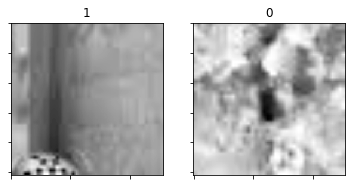

In [0]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(1, 2)
for idx, ax in enumerate(axes):
  img, lbl = train_set[random.randint(0,len(train_set))]
  ax.imshow(img[0], cmap='gray')
  ax.set_title(lbl)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

In [0]:
model = nn.Sequential(models.resnet101(pretrained=True), Net())
# model = torch.load('OrganicModel.pt')
torch.save(model.state_dict(), '/content/drive/My Drive/model.pt')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = lr,
    momentum = momentum
)

for e in range(num_epochs):
    print('Training epoch {}'.format(e))
    train(model, criterion, train_loader, optimizer, device)
    print('Testing on validation set')
    test(model, val_loader, device)

torch.save(model.state_dict(), '/content/drive/My Drive/model.pt')


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 57.6MB/s]


Training epoch 0
	batch   20: loss=0.525
	batch   40: loss=0.531
	batch   60: loss=0.557
	batch   80: loss=0.588
	batch  100: loss=0.592
	batch  120: loss=0.568
	batch  140: loss=0.575
	batch  160: loss=0.586
	batch  180: loss=0.554
	batch  200: loss=0.579
	batch  220: loss=0.553
	batch  240: loss=0.544
	batch  260: loss=0.556
Testing on validation set
	acc=0.762
[[1996  583]
 [ 460 1352]]
Training epoch 1
	batch   20: loss=0.547
	batch   40: loss=0.596
	batch   60: loss=0.576
	batch   80: loss=0.556
	batch  100: loss=0.548
	batch  120: loss=0.572
	batch  140: loss=0.557
	batch  160: loss=0.595
	batch  180: loss=0.568
	batch  200: loss=0.584
	batch  220: loss=0.576
	batch  240: loss=0.556
	batch  260: loss=0.569
Testing on validation set
	acc=0.739
[[1795  484]
 [ 661 1451]]
Training epoch 2
	batch   20: loss=0.569
	batch   40: loss=0.541
	batch   60: loss=0.549
	batch   80: loss=0.534
	batch  100: loss=0.547
	batch  120: loss=0.539
	batch  140: loss=0.531
	batch  160: loss=0.526
	batc